# Imports

In [1]:
from fastai.tabular.all import *
from fastai.vision.all import *
import fastinference

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import yellowbrick as yb

In [5]:
path = Path('/path/to/folder')

In [7]:
torch.cuda.set_device(0)

In [8]:
train_df = pd.read_csv(path/'COVID_HMAR_DATABASE.csv')

In [9]:
train_df.dropna(thresh=20, inplace=True)

In [10]:
len(train_df)

8713

In [11]:
#Since not all the rows have a corresponding image, filtering is performed using a ls of the files that are present in the images folder
images_df = pd.read_csv(path/'Images_to_use', header=None)

In [12]:
images_df.columns = ['Filename']

In [13]:
train_df_ready = pd.merge(train_df, images_df, how='inner', on=['Filename'])

In [14]:
train_df_ready.Label = train_df_ready.Label.str.replace('Heart_attack', 'Heart_failure')

In [15]:
len(train_df_ready)

8578

## Explore Tabular Database

In [16]:
from tableone import TableOne

In [17]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/jgibert/anaconda3/envs/fastai2/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
df_to_plot = train_df_ready.rename(columns={'Edad': 'Age', 'Sexe': 'Sex', 'BASFILS':'%Basophils', 'BASFILS_T':'Total Basophils',
                  'EOSINFILS':'%Eosinophils', 'EOSINFILS_T':'Total Eosinophils', 'H._C._M.':'MCH', #Mean corpuscular hemoglobin',
                  'HEMATCRIT': 'Hematrocrit', 'HEMATIES': 'Red Blood Cells', 'HEMOGLOBINA': 'Hemoglobin',
                   'LEUCCITS': 'Leukocytes', 'LIMFCITS': '%Lymphocytes', 'LIMFCITS_T': 'Total Lymphocytes', 
                   'M._C._H._C.' : 'MCHC', #Mean Corpuscular Hemoglobin Concentration
                   'MONCITS': '%Monocytes', 'MONCITS_T': 'Total Monocytes', 'NEUTRFILS': '%Neutrophils',
                   'NEUTRFILS_T': 'Total Neutrophils', 'P-LCR': 'P-LCR', #Platelet large cell ratio, 
                   'P._D._W.': 'PDW', #Platelet Distribution Width
                   'PLAQUETES': 'Platelets', 'RDW-CV': 'RDW-CV', #Red cell distribution width coefficient of variation
                   'RDW-SD': 'RDW-SD', #ditto 
                   'V._C._M.': 'MCV', #Mean Corpuscular Value
                   'V._P._M.': 'MPV' #Mean platelet Volume
                  })

In [19]:
df_to_plot.columns

Index(['Filename', 'Label', 'Age', 'Sex', '%Basophils', 'Total Basophils',
       '%Eosinophils', 'Total Eosinophils', 'MCH', 'Hematrocrit',
       'Red Blood Cells', 'Hemoglobin', 'Leukocytes', '%Lymphocytes',
       'Total Lymphocytes', 'MCHC', '%Monocytes', 'Total Monocytes',
       '%Neutrophils', 'Total Neutrophils', 'P-LCR', 'PDW', 'Platelets',
       'RDW-CV', 'RDW-SD', 'MCV', 'MPV'],
      dtype='object')

In [20]:
columns = ['Age', 'Sex', '%Basophils', 'Total Basophils',
       '%Eosinophils', 'Total Eosinophils', 'MCH', 'Hematrocrit',
       'Red Blood Cells', 'Hemoglobin', 'Leukocytes', '%Lymphocytes',
       'Total Lymphocytes', 'MCHC', '%Monocytes', 'Total Monocytes',
       '%Neutrophils', 'Total Neutrophils', 'P-LCR', 'PDW', 'Platelets',
       'RDW-CV', 'RDW-SD', 'MCV', 'MPV']

nonnormal = ['%Basophils', 'Total Basophils',
       '%Eosinophils', 'Total Eosinophils', 'MCH', 'Hematrocrit',
       'Red Blood Cells', 'Hemoglobin', 'Leukocytes', '%Lymphocytes',
       'Total Lymphocytes', 'MCHC', '%Monocytes', 'Total Monocytes',
       '%Neutrophils', 'Total Neutrophils', 'P-LCR', 'PDW', 'Platelets',
       'RDW-CV', 'RDW-SD', 'MCV', 'MPV']

In [21]:
mytable = TableOne(df_to_plot, columns=columns, nonnormal=nonnormal, groupby='Label', missing=False, decimals=3)

In [22]:
mytable

Grouped by Label                                                                                                            
                                                       Overall                      COVID                    Control              Heart_failure                  Pneumonia
n                                                         8578                       1171                       5909                       1008                        490
Age, mean (SD)                                 66.128 (18.353)            66.013 (16.612)            63.165 (18.281)            82.823 (10.731)            67.786 (17.011)
Sex, n (%)                        H              5023 (58.557)               677 (57.814)              3598 (60.890)               460 (45.635)               288 (58.776)
                                  M              3555 (41.443)               494 (42.186)              2311 (39.110)               548 (54.365)               202 (41.224)
%Basophils, median [Q1,Q3]                 0.300 [0.200,0.525]        0.200 [0.100,0.300]        0.400 [0.200,0.600]        0.333 [0.200,0.500]        0.300 [0.175,0.500]
Total Basophils, median [Q1,Q3]            0.030 [0.020,0.050]        0.010 [0.010,0.020]        0.040 [0.020,0.055]        0.030 [0.020,0.050]        0.030 [0.017,0.060]
%Eosinophils, median [Q1,Q3]               0.700 [0.100,1.900]        0.000 [0.000,0.300]        0.950 [0.175,2.150]        0.900 [0.200,2.100]        0.600 [0.000,2.200]
Total Eosinophils, median [Q1,Q3]          0.060 [0.010,0.160]        0.000 [0.000,0.020]        0.080 [0.020,0.180]        0.070 [0.020,0.160]        0.060 [0.005,0.200]
MCH, median [Q1,Q3]                     29.650 [28.300,30.900]     29.400 [28.300,30.550]     29.800 [28.433,31.050]     29.200 [27.387,30.700]     29.600 [28.500,30.700]
Hematrocrit, median [Q1,Q3]             38.000 [33.100,42.250]     40.000 [36.600,43.300]     38.500 [33.600,42.700]     35.200 [31.400,39.200]     32.025 [28.512,36.100]
Red Blood Cells, median [Q1,Q3]            4.290 [3.710,4.809]        4.550 [4.080,4.935]        4.360 [3.743,4.860]        3.930 [3.494,4.370]        3.630 [3.160,4.070]
Hemoglobin, median [Q1,Q3]              12.600 [10.800,14.150]     13.300 [12.000,14.433]     12.900 [11.067,14.400]     11.300 [10.000,12.700]      10.500 [9.200,12.100]
Leukocytes, median [Q1,Q3]                9.020 [6.771,12.100]        6.420 [5.060,8.860]       9.450 [7.260,12.655]       8.660 [6.894,11.072]      10.950 [7.700,14.781]
%Lymphocytes, median [Q1,Q3]             15.350 [8.333,25.100]      14.900 [9.475,21.900]      16.800 [8.400,27.600]      12.700 [8.200,18.912]      10.100 [5.763,17.850]
Total Lymphocytes, median [Q1,Q3]          1.310 [0.800,2.010]        0.930 [0.688,1.270]        1.525 [0.920,2.240]        1.070 [0.740,1.560]        1.140 [0.605,1.680]
MCHC, median [Q1,Q3]                    33.233 [32.200,34.167]     33.000 [32.100,33.900]     33.467 [32.500,34.400]     32.300 [31.300,33.200]     32.717 [31.600,33.750]
%Monocytes, median [Q1,Q3]                 7.100 [5.300,8.900]        6.500 [4.400,9.000]        7.100 [5.400,8.800]        8.000 [6.237,9.812]        6.300 [4.308,8.600]
Total Monocytes, median [Q1,Q3]            0.635 [0.442,0.840]        0.415 [0.290,0.600]        0.660 [0.480,0.870]        0.690 [0.510,0.890]        0.690 [0.440,0.890]
%Neutrophils, median [Q1,Q3]            75.200 [63.600,84.400]     77.000 [69.100,84.600]     73.467 [60.900,84.100]     76.800 [69.183,82.900]     81.050 [70.925,89.100]
Total Neutrophils, median [Q1,Q3]          6.450 [4.400,9.650]        4.870 [3.470,7.095]       6.673 [4.520,10.080]        6.470 [4.950,8.654]       8.418 [5.500,12.360]
P-LCR, median [Q1,Q3]                   30.700 [25.167,36.900]     30.800 [25.300,36.300]     30.317 [24.950,36.500]     32.858 [26.992,38.400]     32.300 [24.000,40.413]
PDW, median [Q1,Q3]                     12.600 [11.100,14.400]     12.600 [11.075,14.200]     12.500 [11.100,14.3

## Preprocessing tabular data

In [24]:
#Let's preprocess tabular data a little
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.0)

In [25]:
vt = sel.fit(train_df_ready.iloc[:,4:27])

In [26]:
vt.variances_

array([1.05001536e-01, 9.52471175e-04, 3.79952032e+00, 3.30608164e-02,
       6.32590008e+00, 4.22711874e+01, 6.15617510e-01, 5.18652754e+00,
       2.66065979e+01, 8.92000000e+01, 2.15542470e+00, 2.27567303e+00,
       1.15601539e+01, 2.29343820e-01, 9.59000000e+01, 2.36846813e+01,
       7.25459093e+01, 6.99642770e+00, 8.79506323e+03, 4.54875718e+00,
       4.93899654e+01, 4.14045733e+01, 1.12498720e+00])

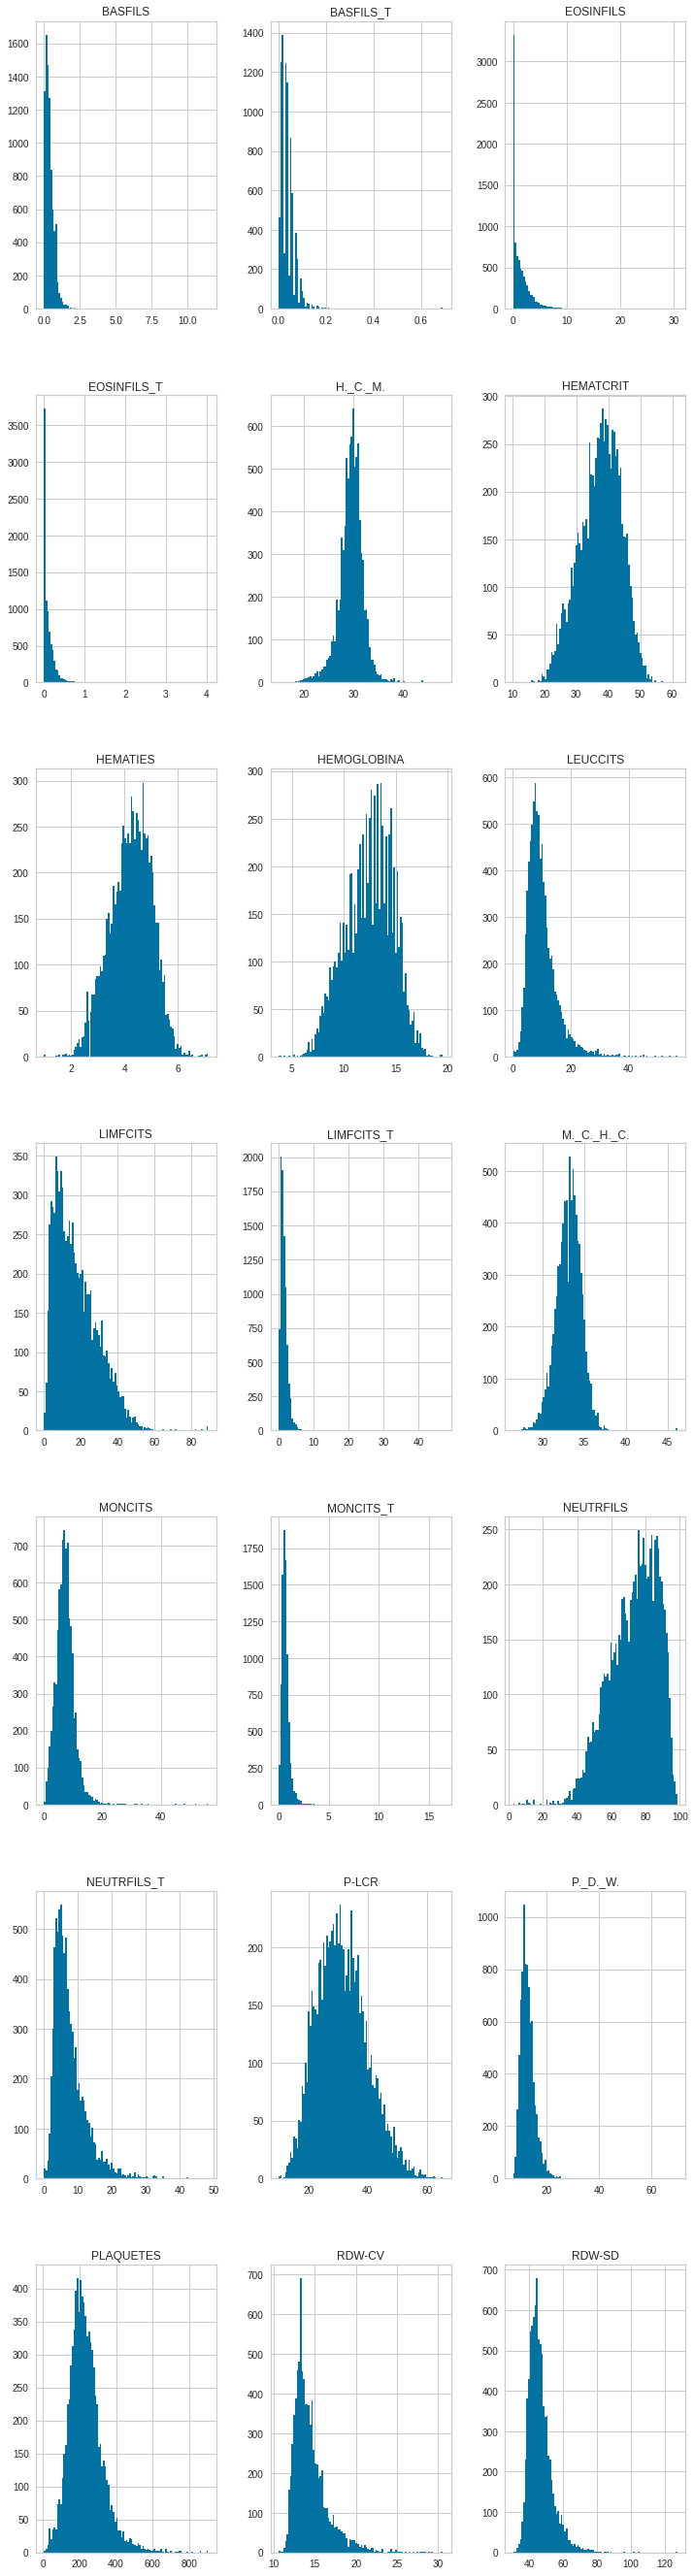

In [27]:
fig, axes = plt.subplots(len(train_df_ready.iloc[:,4:27].columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        train_df_ready.iloc[:,4:27].hist(column = train_df_ready.iloc[:,4:27].columns[i], bins = 100, ax=axis)
        i = i+1

In [28]:
from sklearn.preprocessing import PowerTransformer 
pt = PowerTransformer(method='box-cox', standardize=True) 
Xt = pt.fit_transform(train_df_ready.iloc[:,4:27]+1e-7)

In [29]:
train_df_ready.iloc[:,4:27].columns

Index(['BASFILS', 'BASFILS_T', 'EOSINFILS', 'EOSINFILS_T', 'H._C._M.',
       'HEMATCRIT', 'HEMATIES', 'HEMOGLOBINA', 'LEUCCITS', 'LIMFCITS',
       'LIMFCITS_T', 'M._C._H._C.', 'MONCITS', 'MONCITS_T', 'NEUTRFILS',
       'NEUTRFILS_T', 'P-LCR', 'P._D._W.', 'PLAQUETES', 'RDW-CV', 'RDW-SD',
       'V._C._M.', 'V._P._M.'],
      dtype='object')

In [30]:
transform = pd.DataFrame(Xt)

In [31]:
transform.columns = train_df_ready.iloc[:,4:27].columns

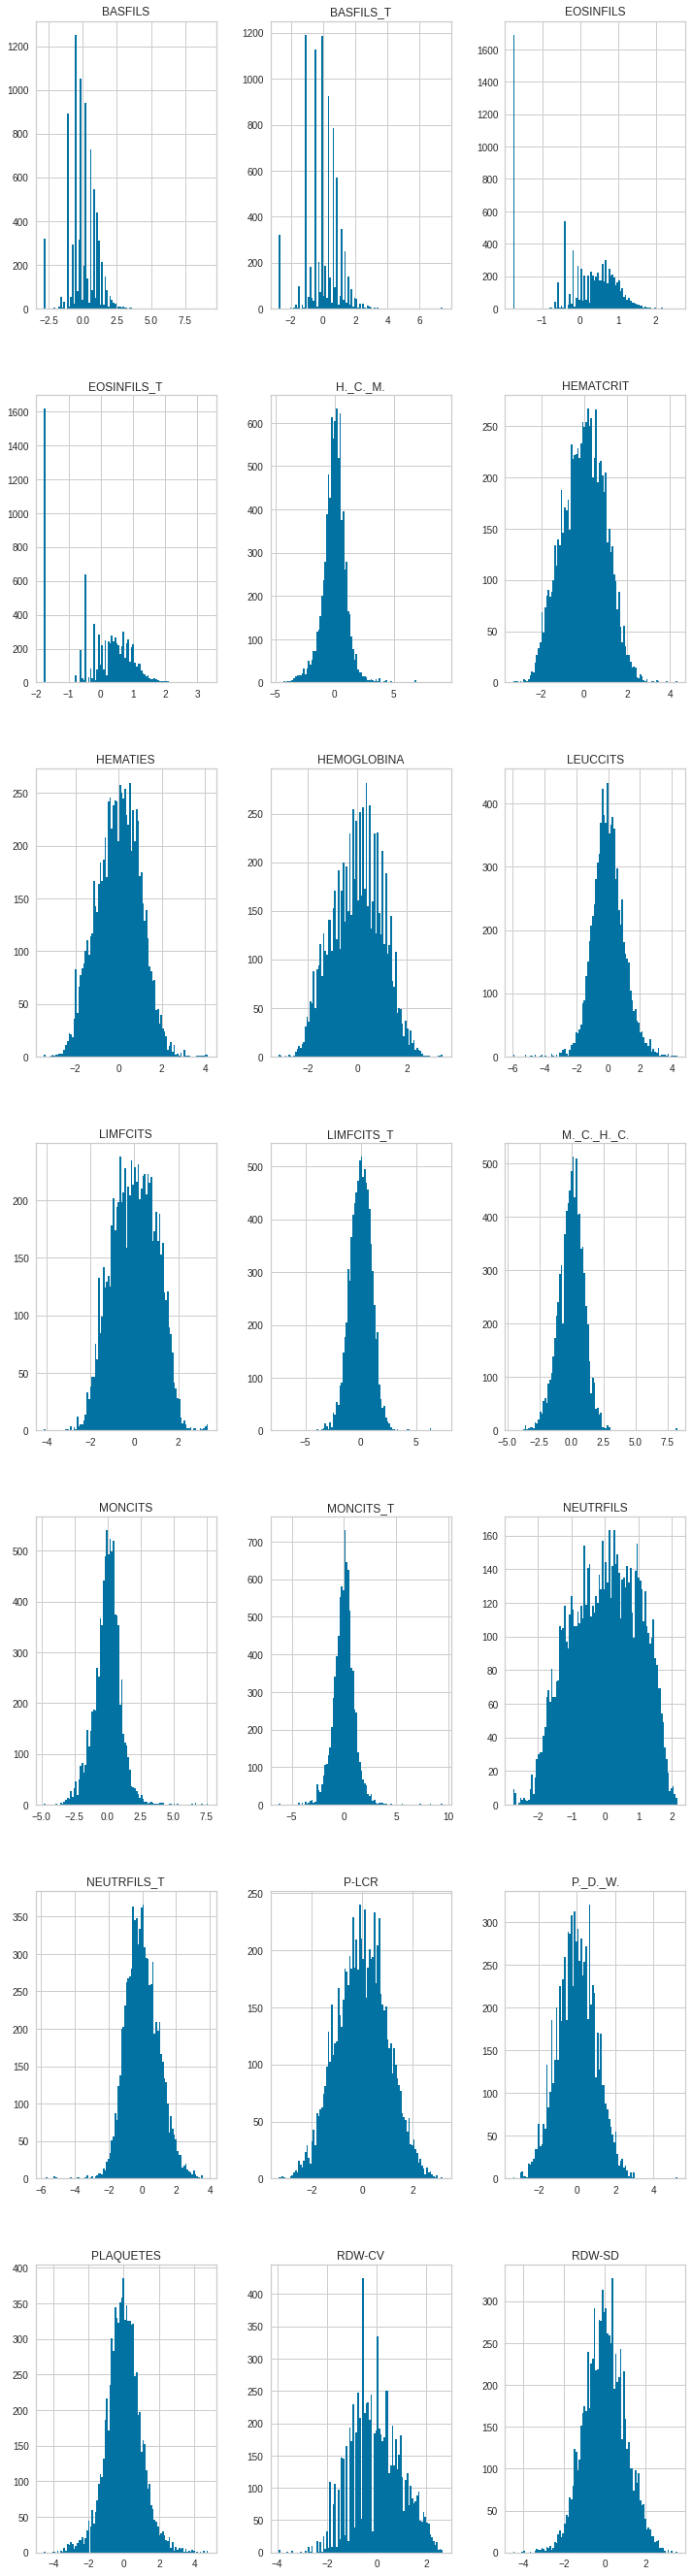

In [32]:
fig, axes = plt.subplots(len(transform.columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        transform.hist(column = transform.columns[i], bins = 100, ax=axis)
        i = i+1

In [33]:
def filter_df_corr(inp_data, corr_val):
    '''
    Returns an array or dataframe (based on type(inp_data) adjusted to drop \
        columns with high correlation to one another. Takes second arg corr_val
        that defines the cutoff

    ----------
    inp_data : np.array, pd.DataFrame
        Values to consider
    corr_val : float
        Value [0, 1] on which to base the correlation cutoff
    '''
    # Creates Correlation Matrix
    if isinstance(inp_data, np.ndarray):
        inp_data = pd.DataFrame(data=inp_data)
        array_flag = True
    else:
        array_flag = False
    corr_matrix = inp_data.corr()

    # Iterates through Correlation Matrix Table to find correlated columns
    drop_cols = []
    n_cols = len(corr_matrix.columns)

    for i in range(n_cols):
        for k in range(i+1, n_cols):
            val = corr_matrix.iloc[k, i]
            col = corr_matrix.columns[i]
            row = corr_matrix.index[k]
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col, "|", row, "|", round(val, 2))
                drop_cols.append(col)

    # Drops the correlated columns
    drop_cols = set(drop_cols)
    inp_data = inp_data.drop(columns=drop_cols)
    # Return same type as inp
    if array_flag:
        return inp_data.values
    else:
        return inp_data

In [34]:
trans_filt = filter_df_corr(transform, 0.95)

EOSINFILS | EOSINFILS_T | 0.98
HEMATCRIT | HEMOGLOBINA | 0.97
LIMFCITS | NEUTRFILS | -0.96
P-LCR | P._D._W. | 0.97
P-LCR | V._P._M. | 0.99
P._D._W. | V._P._M. | 0.96


In [35]:
droped_cols = ['EOSINFILS', 'HEMATCRIT', 'LIMFCITS', 'P-LCR', 'P._D._W.']

In [36]:
train_df_filt_norm = train_df_ready.iloc[:,0:4].join(trans_filt)

In [37]:
train_df_filt_norm.columns

Index(['Filename', 'Label', 'Edad', 'Sexe', 'BASFILS', 'BASFILS_T',
       'EOSINFILS_T', 'H._C._M.', 'HEMATIES', 'HEMOGLOBINA', 'LEUCCITS',
       'LIMFCITS_T', 'M._C._H._C.', 'MONCITS', 'MONCITS_T', 'NEUTRFILS',
       'NEUTRFILS_T', 'PLAQUETES', 'RDW-CV', 'RDW-SD', 'V._C._M.', 'V._P._M.'],
      dtype='object')

### Next step in 2_Training_Single_Models